In [8]:
import pandas as pd

Refer to [link](https://files.grouplens.org/datasets/movielens/ml-25m-README.html) for more information about this open source dataset.

In [49]:
g_scores_df = pd.read_csv('../data/genome-scores.csv')
g_tags_df = pd.read_csv('../data/genome-tags.csv')
links_df = pd.read_csv('../data/links.csv')
ratings_df = pd.read_csv('../data/ratings.csv')
tags_df = pd.read_csv('../data/tags.csv')
movies_df = pd.read_csv('../data/movies.csv')

# What are we doing?
First thing that we need to do is to prepare the data. So what do we need?
We have a lot of information here so let's go dataset by dataset

- __Genome-scores__: We get relevance for tags from this and this will allow us to reduce the number of tags associated with each movie. So what does high / low relevance mean? Where should we place our threshold?
- __g_tags_df__: This is a bridging table and will allow us to (1) provie a more human readable output for out system and (2) can be used with NLP techniques (Content-based)
- __links_df__: Another bridging table that will allow us to easily(?) merge our enrichment set. (Content-based?)
- __ratings_df__: The crux and meat of our data. (1) What ratings are we seeing? How do the distributions look? (sample) (2) How does the time of events for watching movies look? Should we include movies from users which were watched 1 year apart? How taste changed so much by that point? Can we test this?
- __tags_df__: Allows us to include more information about a movie. (Content-based)
- __movies_df__: (1) Add genres (Content-based)

Additionally - We should probably include a general genre trend e.g. Seasonal (Romance towards Christmas), Blockbusters (Action, Comedy)

Further to the ordinary recommender system which tends to heavily bias towards films that have already gained traction, we want to introduce common categories of films that garner interest. We will include:

- Wild card: A film that doesn't have many reviews but still shows high rating for the consumer
- Bad movie: A movie that's so bad it's good - think Tommy Wiseau
- Breaking the mould: Consider a movie that isn't normally up your street but something we think you might enjoy.


## Tag Relevance Scores

In [3]:
g_scores_df.head()

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


### What is the distribution?
How have relevance scores been scored? Manual or is this frequency based?

<AxesSubplot:ylabel='Frequency'>

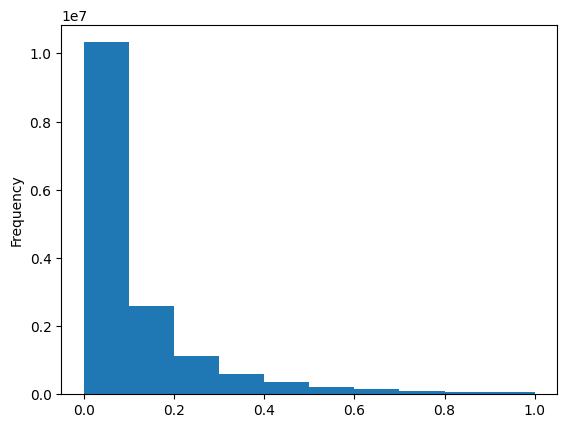

In [4]:
g_scores_df['relevance'].plot(kind='hist')

In [5]:
## We've found that > 6000 tags have a relevance of greater than 0.99, so let's take a look at what they are
g_scores_df[g_scores_df['relevance'] > 0.99].describe()

,movieId,tagId,relevance
count,6591.000000,6591.000000,6591.000000
mean,38405.554696,611.644970,0.994968
std,47084.649253,333.235151,0.002845
min,1.000000,1.000000,0.990250
25%,3435.000000,334.500000,0.992500
50%,7454.000000,631.000000,0.995000
75%,66253.500000,927.000000,0.997250
max,180737.000000,1128.000000,1.000000


In [6]:
g_scores_df[g_scores_df['relevance'] < 0.01].describe()

,movieId,tagId,relevance
count,1.168522e+06,1.168522e+06,1.168522e+06
mean,4.628220e+04,5.507431e+02,6.445020e-03
std,5.308064e+04,3.357408e+02,2.228687e-03
min,1.000000e+00,1.000000e+00,2.500000e-04
25%,4.237000e+03,2.250000e+02,4.750000e-03
50%,2.575700e+04,5.710000e+02,6.750000e-03
75%,8.164100e+04,8.260000e+02,8.250000e-03
max,2.064990e+05,1.128000e+03,9.750000e-03


In [7]:
g_tags_df.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [8]:
subset_g_scores_df_best = g_scores_df[g_scores_df['relevance'] > 0.99][:20]
subset_g_scores_df_best['tag'] = subset_g_scores_df_best['tagId'].apply(lambda x: g_tags_df[g_tags_df['tagId'] == x]['tag'].values[0])
subset_g_scores_df_best['tag']

243      computer animation
785         pixar animation
1035                   toys
10152                   007
10153          007 (series)
10302                  bond
12090             president
13365                 spoof
13599             animation
16575               pirates
16792          swashbuckler
16835         treasure hunt
17106                casino
17342              gangster
17343             gangsters
17541                 mafia
17577                   mob
17660       organized crime
24590         serial killer
24896              assassin
Name: tag, dtype: object

In [9]:
subset_g_scores_df_worst = g_scores_df[g_scores_df['relevance'] < 0.01][:20]
subset_g_scores_df_worst['tag'] = subset_g_scores_df_worst['tagId'].apply(lambda x: g_tags_df[g_tags_df['tagId'] == x]['tag'].values[0])
subset_g_scores_df_worst['tag']

13                  9/11
73                arnold
87            australian
88     author:alan moore
102           bad sequel
103               ballet
105             baseball
116               batman
118              beatles
186               casino
208         christianity
224        coen brothers
294        depp & burton
346          emma watson
391       figure skating
475            gross-out
479             gulf war
487             handycam
488      hannibal lecter
540                india
Name: tag, dtype: object

In [10]:
tags_df.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [11]:
## Now that we've found some of the best and worst for relevance, let's find their frequency in the data
def tag_counts(tag_list, tag):
    tag_count = tag_list.count(tag)
    return tag_count

In [12]:
subset_g_scores_df_worst['tag_count'] = subset_g_scores_df_worst['tag'].apply(lambda x: tag_counts(tags_df['tag'].to_list(), x))
subset_g_scores_df_best['tag_count'] = subset_g_scores_df_best['tag'].apply(lambda x: tag_counts(tags_df['tag'].to_list(), x))

In [13]:
print(subset_g_scores_df_worst)

     movieId  tagId  relevance                tag  tag_count
13         1     14    0.00700               9/11         66
73         1     74    0.00975             arnold        236
87         1     88    0.00575         australian         75
88         1     89    0.00675  author:alan moore          0
102        1    103    0.00725         bad sequel         80
103        1    104    0.00400             ballet        208
105        1    106    0.00525           baseball        291
116        1    117    0.00550             batman        101
118        1    119    0.00375            beatles         10
186        1    187    0.00900             casino        190
208        1    209    0.00825       christianity        268
224        1    225    0.00675      coen brothers        142
294        1    295    0.00750      depp & burton          1
346        1    347    0.00800        emma watson         17
391        1    392    0.00600     figure skating         56
475        1    476    0

In [14]:
print(subset_g_scores_df_best)

       movieId  tagId  relevance                 tag  tag_count
243          1    244    0.99875  computer animation        313
785          1    786    0.99575     pixar animation         17
1035         1   1036    0.99925                toys         80
10152       10      1    0.99950                 007        214
10153       10      2    1.00000        007 (series)         75
10302       10    151    0.99900                bond         44
12090       11    811    0.99675           president         95
13365       12    958    0.99275               spoof        398
13599       13     64    0.99200           animation       2661
16575       15    784    0.99025             pirates        444
16792       15   1001    0.99175        swashbuckler        129
16835       15   1044    0.99775       treasure hunt        308
17106       16    187    0.99325              casino        190
17342       16    423    0.99150            gangster        558
17343       16    424    0.99025        

Since the description of our data tells us *'The tag genome was computed using a machine learning algorithm on user-contributed content including tags, ratings, and textual reviews.'* we can assume from our findings that the relevance score does not correspond to the frequency. We might be able to assume that the relevance score is based on the output of the machine learning algorithm used to generate it. So how many tags on average are associated to each movie?

In [15]:
g_scores_df.groupby('movieId')['movieId'].count().sort_index()

movieId
1         1128
2         1128
3         1128
4         1128
5         1128
          ... 
205072    1128
205076    1128
205383    1128
205425    1128
206499    1128
Name: movieId, Length: 13816, dtype: int64

In [16]:
# Quick sanity check. We have 13816 unique movie Id's and for each movie, there appears to be 1128 tags. Does this match the dataframe shape?
print(g_scores_df.shape)
print(g_tags_df.shape)
13816*1128

(15584448, 3)
(1128, 2)


15584448

Great, now since we know that each movie has the same tags applied, we need to whittle them down to the most relevant for each movie. So let's take a look at what we've got and where we should set a sensible threshold. 

In [17]:
## Since we don't really need more than 100 tags, 
g_scores_df['points_bin'] = pd.qcut(g_scores_df['relevance'], q=20)
agg_g_scores_df = g_scores_df.groupby('movieId')['points_bin'].value_counts().to_frame()

In [18]:
agg_g_scores_df.head(40)

points_bin
movieId                                
1       (0.447, 1.0]                112
        (0.222, 0.298]               78
        (0.298, 0.447]               75
        (0.174, 0.222]               71
        (0.0958, 0.115]              69
        (0.0565, 0.067]              62
        (0.141, 0.174]               61
        (0.0287, 0.0342]             56
        (0.115, 0.141]               56
        (0.0342, 0.0405]             55
        (0.0478, 0.0565]             55
        (0.024, 0.0287]              52
        (0.08, 0.0958]               50
        (0.0157, 0.0197]             48
        (0.067, 0.08]                47
        (0.0405, 0.0478]             39
        (0.0117, 0.0157]             38
        (0.0197, 0.024]              37
        (-0.00075, 0.00775]          34
        (0.00775, 0.0117]            33
2       (0.067, 0.08]                71
        (0.0565, 0.067]              69
        (0.0958, 0.115]              69
        (0.0405, 0.0478]             67
        (0.222, 0.298]               67
        (0.141, 0.174]               64
        (0.447, 1.0]                 63
        (0.0342, 0.0405]             61
        (0.08, 0.0958]               58
        (0.0157, 0.0197]             57
        (0.115, 0.141]               54
        (0.174, 0.222]               54
        (0.0478, 0.0565]             51
        (0.024, 0.0287]              51
        (0.0197, 0.024]              50
        (0.0287, 0.0342]             49
        (0.00775, 0.0117]            49
        (0.0117, 0.0157]             47
        (0.298, 0.447]               44
        (-0.00075, 0.00775]          33

In [19]:
## Down from 15m to ~ 615,000
g_scores_df_gt_5 = g_scores_df[g_scores_df['relevance'] > 0.5]
g_scores_df_gt_5.shape

(614423, 4)

In [20]:
g_scores_df_gt_5.groupby('movieId')['relevance'].value_counts().to_frame()
g_scores_df_gt_5.head()

,movieId,tagId,relevance,points_bin
10,1,11,0.58025,"(0.447, 1.0]"
18,1,19,0.66250,"(0.447, 1.0]"
28,1,29,0.89375,"(0.447, 1.0]"
29,1,30,0.67625,"(0.447, 1.0]"
60,1,61,0.61750,"(0.447, 1.0]"


<AxesSubplot:ylabel='Frequency'>

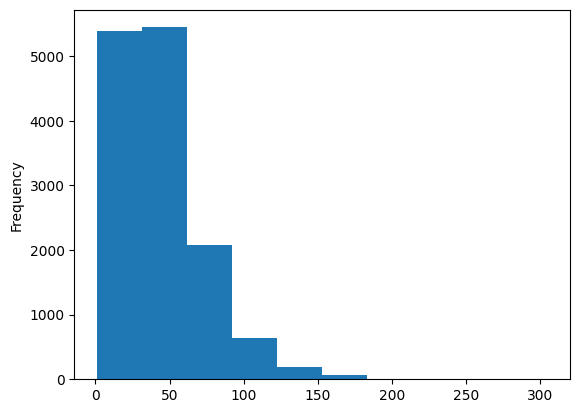

In [21]:
g_scores_df_gt_5.groupby('movieId')['movieId'].count().plot(kind='hist')

In [22]:
## This tell us that every movie has at least one tag, most have more than 25. 
g_scores_df_gt_5.groupby('movieId')['movieId'].count().describe()

count    13816.000000
mean        44.471844
std         27.937181
min          1.000000
25%         25.000000
50%         37.000000
75%         57.000000
max        305.000000
Name: movieId, dtype: float64

From this we choose to set the threshold for the tag reference to 0.5. In this, we still enrich the information that we have but we will need to keep an eye on this throughout the analysis, revisiting and adjusting the threshold if needed. 

## Aggregate Movie Data

In [23]:
sample_ratings_df = ratings_df.sample(20000)

In [24]:
from datetime import datetime
sample_ratings_df['date'] = sample_ratings_df.timestamp.apply(lambda x: datetime.fromtimestamp(x).strftime('%m-%y'))

In [25]:
vote_counts = ratings_df.pivot_table(columns=['movieId'], aggfunc='size')
sample_ratings_df['votes'] = sample_ratings_df.movieId.apply(lambda x: vote_counts.loc[x])

In [26]:
rolling_rating = sample_ratings_df.groupby('movieId')['rating', 'votes', 'date'].rolling(3).mean()
rolling_rating.head

/tmp/ipykernel_4747/442709438.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  rolling_rating = sample_ratings_df.groupby('movieId')['rating', 'votes', 'date'].rolling(3).mean()
/tmp/ipykernel_4747/442709438.py:1: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['date'], dtype='object')
  rolling_rating = sample_ratings_df.groupby('movieId')['rating', 'votes', 'date'].rolling(3).mean()


<bound method NDFrame.head of                     rating    votes
movieId                            
1       20090662       NaN      NaN
        9148179        NaN      NaN
        16911785  2.833333  57309.0
        12478151  3.166667  57309.0
        24314104  3.833333  57309.0
...                    ...      ...
201588  22431201       NaN      NaN
202429  19504278       NaN      NaN
        24140361       NaN      NaN
202836  11150896       NaN      NaN
205383  14662142       NaN      NaN

[20000 rows x 2 columns]>

In [27]:
movie_dataframe = ratings_df.copy()
movie_dataframe.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [40]:
vote_counts = ratings_df.pivot_table(columns=['movieId'], aggfunc='size')
vote_counts.head()

movieId
1    57309
2    24228
3    11804
4     2523
5    11714
dtype: int64

In [47]:
movie_ratings = movie_dataframe.groupby('movieId')['rating'].mean()
movie_ratings.head()

movieId
1    3.893708
2    3.251527
3    3.142028
4    2.853547
5    3.058434
Name: rating, dtype: float64

In [53]:
movie_data_grouped = pd.concat([movie_ratings, vote_counts], axis=1).reset_index()
movie_data_grouped.rename(columns = {0:"votes"}, inplace=True)
movie_data_grouped.head()

,movieId,rating,votes
0,1,3.893708,57309
1,2,3.251527,24228
2,3,3.142028,11804
3,4,2.853547,2523
4,5,3.058434,11714


1 81491


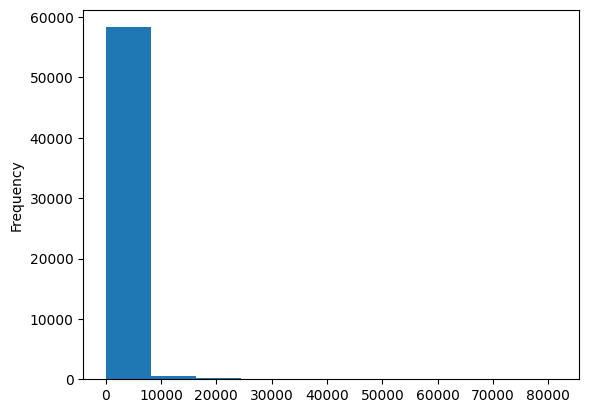

In [61]:
movie_data_grouped['votes'].plot(kind='hist')
print(min(movie_data_grouped['votes']), max(movie_data_grouped['votes']))

1 81491


(0.0, 2000.0)

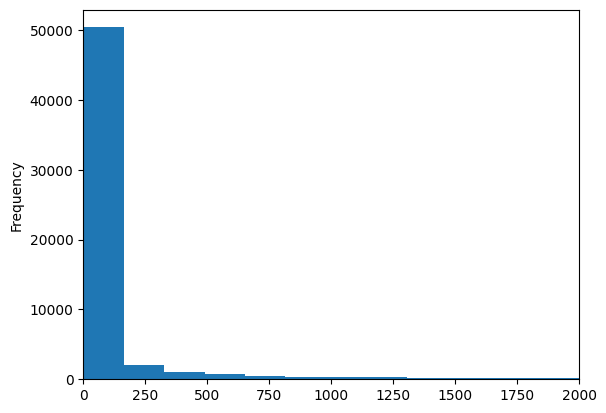

In [68]:
import matplotlib.pyplot as plt
movie_data_grouped['votes'].plot(kind='hist', bins=500)
print(min(movie_data_grouped['votes']), max(movie_data_grouped['votes']))
plt.xlim(0, 2000)

In [69]:
movie_data_grouped['votes'].describe()

count    59047.000000
mean       423.393144
std       2477.885821
min          1.000000
25%          2.000000
50%          6.000000
75%         36.000000
max      81491.000000
Name: votes, dtype: float64

Though the mean number of votes is 423, this is driven by a small proportion of popular movies. Let's use the 3rd IQR as our limit. We don't want to include all movies but we also don't want to exclude new movies / movies that might be of interest despite popularity. 

The following formula is the IMDB suggested weighting for movies. 

In [72]:
def weighted_rating(x, m, C):
    v = x['votes']
    R = x['rating']
    ## Penalises movie ratings that do not have as many votes
    ## Gives a proporionate amount of average rating back
    return (v/(v+m) * R) + (m/(m+v) * C)

Is this representative?
- It penalises highly rated movies that have lower number of votes - this is to factor in a level of confidence - the less votes, the less general consensus we have about a movei - but wait, not everyone likes the same movies -- which should factor this in.
- It gives more weighting to lowly rated movies with lower number of votes.

Threshold amount is 50, average vote is 5.

| | 1 | 2 | 3 | 4 |
|--|--|--|--|--|
| Votes | 70 | 70 | 2000 | 2000 |
| Avg rating from users | 8 | 4 | 8 | 4 |
| Weighted rating | 6.75 | 4.42 | 7.93 | 4.0244 |

From this, we can see that lower ratings are bumped up while higher ratings are penalised.



In [83]:
def try_this(m, v, R, C):
    w_user_rating = v/(v+m) * R
    w_avg_rating = m/(m+v) * C
    print(w_user_rating+w_avg_rating)

In [84]:
try_this(50, 70, 8, 5)
try_this(50, 70, 4, 5)
try_this(50, 2000, 8, 5)
try_this(50, 2000, 4, 5)

6.75
4.416666666666667
7.926829268292683
4.024390243902439


In [93]:
min_votes = 36
mean_rating = movie_data_grouped['rating'].mean()
print(mean_rating)

3.0713739209511313


In [94]:
movie_data_grouped['weighted_rating'] = weighted_rating(movie_data_grouped, min_votes, mean_rating)
movie_data_grouped.tail(20)

,movieId,rating,votes,weighted_rating,diff
59027,209121,4.00,1,3.096472,0.926310
59028,209123,4.00,1,3.096472,0.926310
59029,209129,4.50,1,3.109985,1.425063
59030,209131,3.50,1,3.082958,0.427557
59031,209133,2.50,2,3.041302,-0.568531
59032,209135,2.25,2,3.028144,-0.817287
59033,209137,0.50,1,3.001877,-2.564962
59034,209139,1.00,1,3.015391,-2.066208
59035,209141,1.00,1,3.015391,-2.066208
59036,209143,1.00,1,3.015391,-2.066208


In [95]:
movie_data_grouped['diff'] = movie_data_grouped.apply(lambda x: x.rating - x.weighted_rating, axis=1)

From the plot below, we can see a visualisation of this. The point of equilibrium being around 3 which is our average rating. The further we get away from our average, the more the ratings divert from their original rating. We are not seeing the same phenomenon that has previously been described here though, instead we are seeing that low rated movies are further penalised while higher rated movies have their rating inflated.

Our previously outlined problem does not appear to present itself in this situation, therefore we cna continue to use the rating calculation as provided by IMDB.

<AxesSubplot:xlabel='rating', ylabel='diff'>

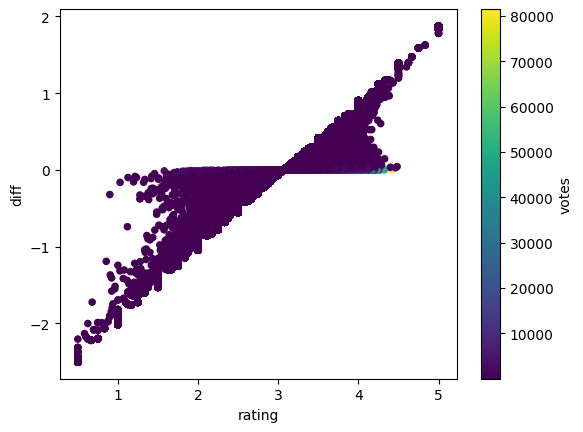

In [96]:
movie_data_grouped.plot.scatter(x='rating', y='diff', c='votes', colormap='viridis')

# Collaborative Filtering
Now that we have a metric indication for the rating of the movie, let's move on to the collaborative part. This relies on the viewing history of other users and their similarities to guide the recommendations.

- Use a weighted system to determine similarity between users 
- Use timestamp to weight the most recent choices as more significant - is this what we want to do? Doesn't the journey dictate / affect the decisions ahead?
- Use movies overall rating to improve recommendation
- 

In [4]:
## Let's have a go at using sci-kit surprise (sklearns library for recommender engines)
import sys
#!{sys.executable} -m pip install scikit-surprise
#!{sys.executable} -m pip install scikit-learn

In [32]:
from sklearn.model_selection import train_test_split
from datetime import datetime
import matplotlib.pyplot as plt

In [11]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


<AxesSubplot:ylabel='Frequency'>

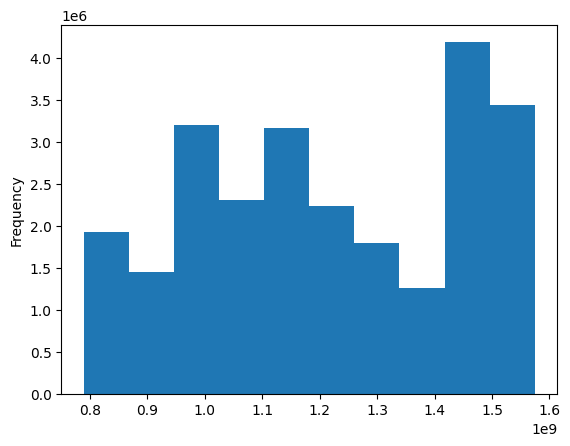

In [12]:
ratings_df['timestamp'].plot(kind='hist')

In [19]:
ratings_df['date'] = ratings_df['timestamp'].apply(lambda x: datetime.fromtimestamp(x).date())

date
2000-11-20    78444
2005-03-22    68531
1999-12-11    57769
2008-10-29    47934
2000-11-21    47381
2005-03-23    46690
1999-12-13    45149
1999-12-12    42635
2000-11-19    35480
1999-12-14    34448
2015-08-17    34319
1999-10-02    28776
2000-11-22    26511
2015-11-04    25202
1999-10-01    24935
1999-10-03    24010
2000-08-03    23798
1999-12-15    23359
2005-04-01    23334
2005-03-24    23166
Name: userId, dtype: int64


<AxesSubplot:xlabel='date'>

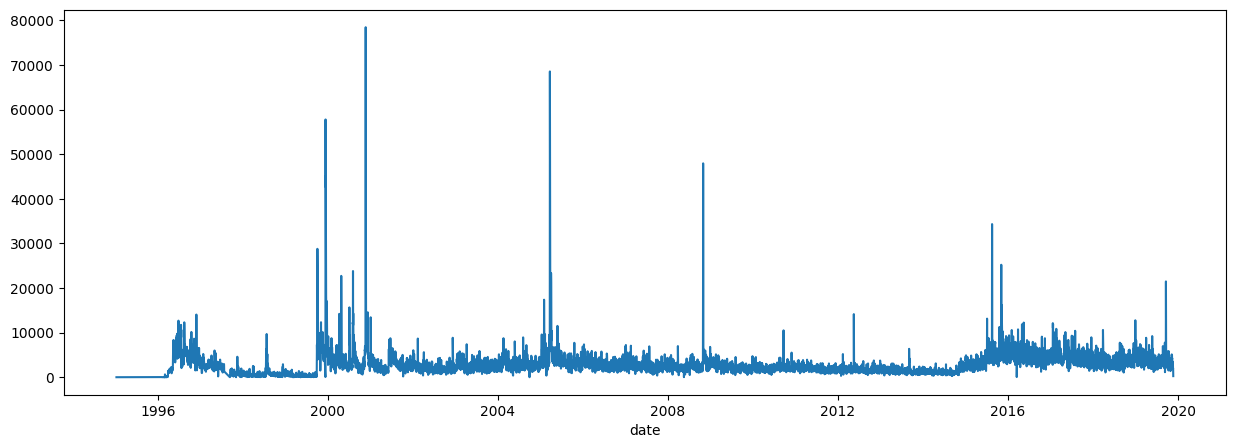

In [40]:
plt.figure(figsize=(15,5))
print(ratings_df.groupby(['date'])['userId'].count().sort_values(ascending=False).head(20))
ratings_df.groupby(['date'])['userId'].count().plot(kind='line')

In [64]:
movies_df.head(5)

,movieId,title,genres,release_date,title_name
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,Toy Story
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,Jumanji
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,Grumpier Old Men
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,Waiting to Exhale
4,5,Father of the Bride Part II (1995),Comedy,1995,Father of the Bride Part II


In [65]:
import re

In [76]:
def find_year(title):
    match = re.match(r'.*([1-3][0-9]{3})', title)
    if match is not None:
        # Then it found a match!
        return int(match.group(1))

movies_df['release_date'] = movies_df['title'].apply(lambda x: find_year(x))
movies_df['title_name'] = movies_df['title'].apply(lambda x: ' '.join(y for y in x.split()[:-1]))

In [77]:
movies_df['release_date'].sort_values().value_counts()#.plot(kind='hist')

2015.0    2513
2016.0    2488
2014.0    2406
2017.0    2375
2013.0    2174
          ... 
1887.0       1
1883.0       1
1880.0       1
1878.0       1
1013.0       1
Name: release_date, Length: 136, dtype: int64

In [79]:
movies_df[movies_df['release_date'] == 1013]

,movieId,title,genres,release_date,title_name
61027,204770,1013 Briar Lane,Horror,1013.0,1013 Briar


In [82]:
movies_df[movies_df['release_date'] == 2000].sort_values(by='release_date').shape

(929, 5)

: 

In [26]:
ratings_df.shape

(25000095, 5)

In [ ]:
X = ratings_df.copy()
y = ratings_df['user_id']

In [ ]:
## Let's make our training / test sets (80/20) split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 1234)